### Adjust Variable

In [18]:
ORIGINAL_CLASSIC_DATA = "data/original/classic/"
ORIGINAL_JAZZ_DATA = "data/original/Jazz/"
RECONSTRUCTED_DATA = "data/reconstructed/"

### Preprocessing data

In [ ]:
import math
import pretty_midi as pm
import math
import os
import numpy as np

def get_midi_files(root_dir):
        midi_files = []
        for root, dirs, files in os.walk(root_dir):
            for file_name in files:
                if file_name.endswith(".mid"):
                    midi_files.append(os.path.join(root, file_name))
        return midi_files


def preprocess_data(root_dir):
    train_dataset = get_midi_files(root_dir)
    right, left = [],[]

    for j in range(len(train_dataset)):
        mid = pm.PrettyMIDI(train_dataset[j])

        fs = 10 # how many parts we will divide one second
        time, tempi = mid.get_tempo_changes()
        duration, song_start, song_end, bpm = 0, 0, mid.get_end_time(), 0
        time = np.insert(time, -1, song_end)
        tempi = np.insert(tempi, -1, tempi[-1])

        song_start = 0
        duration = mid.get_end_time()
        song_end = math.ceil(mid.get_end_time())
        
        hand_dict = {}
        pitch_list = []
        for i, inst in enumerate(mid.instruments):
            inst_key = inst.program // 8
            
            if inst_key > 0:
                continue

            piano_roll = inst.get_piano_roll(times=np.arange(0, mid.get_end_time(), 1.0 / fs))
            
            if np.sum(piano_roll) == 0:
                continue
            
            hand_pitch = np.where(piano_roll)
            pitch_list.append(np.average(hand_pitch[0]))

        if not pitch_list:
            continue
        elif len(pitch_list) == 1:
            print(f"{j} {train_dataset[j]}")
            hand_dict['right'] = mid.instruments[np.argmax(pitch_list)].get_piano_roll(times=np.arange(0, mid.get_end_time(), 1.0 / fs))
            hand_dict['left'] = np.zeros((piano_roll.shape[0], piano_roll.shape[1]))
        else:
            print(f"{j} {train_dataset[j]}")
            hand_dict['right'] = mid.instruments[np.argmax(pitch_list)].get_piano_roll(times=np.arange(0, mid.get_end_time(), 1.0 / fs))
            hand_dict['left'] = mid.instruments[np.argmin(pitch_list)].get_piano_roll(times=np.arange(0, mid.get_end_time(), 1.0 / fs))

        for hand in hand_dict.keys():
            hand_dict[hand] = np.where(hand_dict[hand] > 0, 1, 0)

        for key, item in hand_dict.items():
            pitch_start = 24
            pitch_stop = 100
            duration = 150
            if key == 'right': right.append(item[pitch_start:pitch_stop, song_start*fs:song_start*fs+duration])
            else: left.append(item[pitch_start:pitch_stop, song_start*fs:song_start*fs+duration])
        
    return right, left


piano_right, piano_left = preprocess_data(ORIGINAL_CLASSIC_DATA)
Jazz_right, Jazz_left = preprocess_data(ORIGINAL_JAZZ_DATA)

### Original Data
create input midi file from the original midi file

In [20]:
def create_midi_from_piano_roll(inst, fs=10):
    pm_obj = pm.PrettyMIDI()
    for i in range(2):
        instrument = pm.Instrument(program=0)
        pm_obj.instruments.append(instrument)
        for pitch, series in enumerate(inst[i]):
            start_time = None
            for i in range(len(series) - 1):
                if series[i] == 0 and series[i + 1] == 1:
                    start_time = i / fs
                elif series[i] == 1 and series[i + 1] == 0:
                    if start_time is None:
                        start_time = i / fs
                    end_time = (i + 1) / fs
                    note = pm.Note(
                        velocity=100,
                        pitch=pitch + 24,
                        start=start_time,
                        end=end_time
                    )
                    instrument.notes.append(note)
    return pm_obj

def convert_to_midi_files(fs=10):
    midi_files = []
    for i in range(4):
        inst_list = [piano_right[i], piano_left[i]]
        pm_obj = create_midi_from_piano_roll(inst_list, fs=fs)
        midi_files.append(pm_obj)
    return midi_files

# Assuming Y_total is obtained

midi_files = convert_to_midi_files()
for i, midi_file in enumerate(midi_files):
    midi_file.write(RECONSTRUCTED_DATA + f'/origin_midi_{i}.mid')


### VAE Model

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_styles=2):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim

        self.encode = Encoder(self.input_dim, self.hidden_dim, self.latent_dim)
        self.decode = Decoder(self.latent_dim, self.hidden_dim, self.input_dim)
        self.style_classifier = StyleClassifier(self.latent_dim, num_styles)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, right=None, left=None, check=False):
        mu, logvar, output = self.encode(x)
        z = self.reparameterize(mu, logvar)
        style_pred = self.style_classifier(z)
        decod = self.decode(z, output)
        return decod, mu, logvar, style_pred

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim

        self.gru_piano_right = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.gru_piano_left = nn.GRU(input_dim, hidden_dim, batch_first=True)
        
        self.dense_layer = nn.Linear(hidden_dim * 2, hidden_dim, bias = True)

        self.fc_mu = nn.Linear(hidden_dim, latent_dim, bias = True)  
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim, bias = True)  
    
    def forward(self, x):
        input_list = torch.chunk(x, 2, dim=1)
        right_input = input_list[0] # torch.Size([Batch Size, Sequence length, input length]) 
        left_input = input_list[1] 

        # initialize hidden state
        h0 = torch.zeros(1, right_input.size(0), self.hidden_dim, device=right_input.device)

        # Forward pass through GRU for each instrument
        o_r, h_r = self.gru_piano_right(right_input, h0)
        o_l, h_l = self.gru_piano_left(left_input, h0)

        output = torch.cat((o_r, o_l), dim=1)
        h = torch.cat((h_r[-1,], h_l[-1,]), dim=1)

        h = self.dense_layer(h)
        h = F.relu(h)
        mu = self.fc_mu(h)
        mu = F.relu(mu)
        logvar = self.fc_logvar(h)
        logvar = F.relu(logvar) + 1e-4
        return mu, logvar, output


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.output_dim = output_dim

        self.latent_to_hidden = nn.Linear(latent_dim, latent_dim, bias = True)

        self.piano_right_layer = nn.Linear(latent_dim, hidden_dim, bias = True)
        self.piano_left_layer = nn.Linear(latent_dim, hidden_dim, bias = True)

        self.r_layer = nn.Linear(hidden_dim, output_dim, bias = True)
        self.l_layer = nn.Linear(hidden_dim, output_dim, bias = True)

        self.gru_piano_right_cell = nn.GRUCell(output_dim, hidden_dim)
        self.gru_piano_left_cell = nn.GRUCell(output_dim, hidden_dim)

        self.fr_layer = nn.Linear(hidden_dim, output_dim, bias = True)
        self.fl_layer = nn.Linear(hidden_dim , output_dim, bias = True) 

    def forward(self, z, output):
        
        h = self.latent_to_hidden(z)
        h = F.relu(h)
        
        right = torch.split(output, 150, dim=1)[0]
        left = torch.split(output, 150, dim=1)[1] 

        right = right.permute(1, 0, 2)
        left = left.permute(1, 0, 2)

        right = self.r_layer(right)
        right = F.tanh(right)
        left = self.l_layer(left)            
        left = F.tanh(left)


        piano_hidden = self.piano_right_layer(h) 
        left_hidden = self.piano_left_layer(h)
        
        right_outputs = []
        left_outputs = []

        for t in range(right.size(0)):
            piano_hidden = self.gru_piano_right_cell(right[t] , piano_hidden)
            left_hidden = self.gru_piano_left_cell(left[t], left_hidden)
            
            right_outputs.append(piano_hidden.unsqueeze(1))
            left_outputs.append(left_hidden.unsqueeze(1))

        # print(right_outputs[0].shape)
        right_outputs = torch.cat(right_outputs, dim=1)
        left_outputs = torch.cat(left_outputs, dim=1)

        right_outputs = self.fr_layer(right_outputs)
        left_outputs = self.fl_layer(left_outputs)
        
        right_outputs = F.sigmoid(right_outputs)
        left_outputs = F.sigmoid(left_outputs)

        output = torch.cat((right_outputs, left_outputs), dim=1)

        return output

class StyleClassifier(nn.Module):
    def __init__(self, latent_dim, num_styles):
        super(StyleClassifier, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, num_styles)

    def forward(self, z):
        x = F.relu(self.fc1(z))
        x = self.fc2(x)
        return F.softmax(x, dim=-1)


### Loss Function
- binary data: binary cross entropy loss function
- biased data: weighted binary using pos_weight
- kl divergence is used to compare the distribution of the output and the input of the model

In [13]:
def elbo_loss_function(recon_x, x, mu, logvar, pos_weight):
    # Binary Cross Entropy Loss
    recon_error = F.binary_cross_entropy(recon_x, x, weight=pos_weight, reduction='mean')

    # KL Divergence Term
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    kl_divergence = torch.mean(kl_divergence)

    # Total ELBO Loss
    loss = recon_error + kl_divergence

    return loss

### Train the Model

In [53]:
vae = VAE(input_dim=76, hidden_dim=512, latent_dim=256)

device = torch.device("cpu")
vae = vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

100%|██████████| 10/10 [03:07<00:00, 18.73s/it]


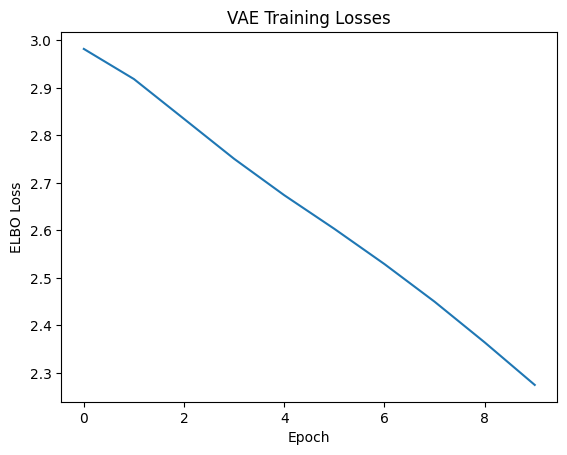

In [66]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

training_losses = []
num_epochs = 10
batch_size = 32 

for epoch in tqdm(range(num_epochs)):
    all_epoch_losses = []

    # Use tqdm for progress visualization
    t = tqdm(range(0, len(piano_right), batch_size), leave=False)
    for start_idx in t:
        end_idx = min(start_idx + batch_size, len(piano_right))
        
        right_input = piano_right[start_idx:end_idx]
        left_input = piano_left[start_idx:end_idx]

        
        tensor_list = []
        tensor_input = []
        for right_data, left_data in zip(right_input, left_input):
            right_tensor = torch.tensor(right_data.T, dtype=torch.float32).to(device)
            if np.sum(left_data) == 0:
                left_tensor = torch.tensor(right_data.T, dtype=torch.float32).to(device)
            else:
                left_tensor = torch.tensor(left_data.T, dtype=torch.float32).to(device)

            tensor_list.append(torch.cat([right_tensor, left_tensor], dim=0))
        
        # Concatenate tensors along the batch dimension
        concatenated_tensors = []

        # Concatenate tensors iteratively from tensor_list[0] to tensor_list[31]
        for i in range(len(tensor_list)):  
            concatenated_tensors.append(tensor_list[i].unsqueeze(0))

        # Concatenate along the specified dimension (dim=0)
        tensor_input = torch.cat(concatenated_tensors, dim=0)
        
        # Zero the gradients
        vae.zero_grad()

        # Forward pass through VAE
        recon, mu, logvar, _ = vae(tensor_input)

        positive_weight = (tensor_input.numel() - tensor_input.sum()) / tensor_input.sum()
        pos_weight = torch.tensor([positive_weight], dtype=torch.float).to(device)

        loss = elbo_loss_function(recon, tensor_input, mu, logvar, pos_weight=pos_weight)
        all_epoch_losses.append(loss.detach().item())

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Update tqdm description with current loss
        t.set_description(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {np.mean(all_epoch_losses):.4f}")

    # Calculate average epoch loss
    avg_epoch_loss = np.mean(all_epoch_losses)
    training_losses.append(avg_epoch_loss)

# Convert training_losses to numpy array
training_losses = np.asarray(training_losses)

# Plot the losses
fig_2d_losses = plt.figure()
plt.plot(training_losses)
plt.xlabel("Epoch")
plt.ylabel("ELBO Loss")
plt.title("VAE Training Losses")
plt.show()

# Save the model
torch.save(vae.state_dict(), "vae_model.pth")


### Reconstruct data
- current idea of chaning the style of the music is to train model with one type of music and reconstruct the other type of music
for example, train the model with classic music and reconstruct the Jazz music or the other way around

Reconstructing MIDI Data


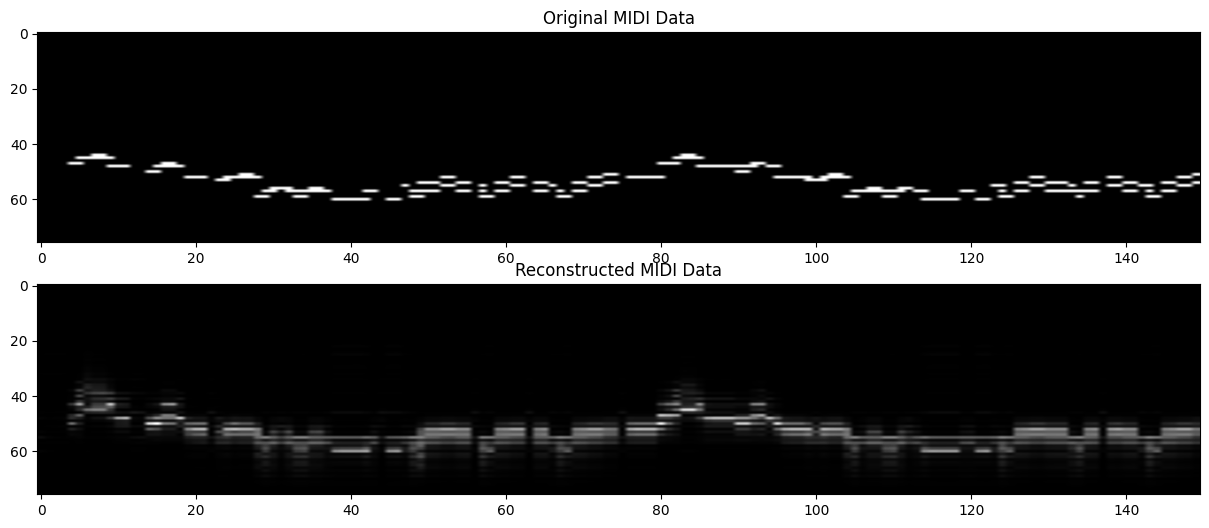

In [67]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mido import MidiFile, MidiTrack, Message

device = "cpu"
vae.load_state_dict(torch.load("vae_model.pth"))
vae = vae.to(device)

print("Reconstructing MIDI Data")

sample_idx = 1
seq_len = 150

# Prepare the original data
original_data = []
right = piano_right[sample_idx].T
left = piano_left[sample_idx].T

right_tensor = torch.tensor(right, dtype=torch.float32).to(device)
left_tensor = torch.tensor(left, dtype=torch.float32).to(device)
input_tensor = torch.cat([right_tensor, left_tensor], dim=0)
input_tensor = input_tensor[:300, :].unsqueeze(0) 

# Get the reconstruction
vae.eval()
with torch.no_grad():
    recon_data_list, _, _, _ = vae(input_tensor)

recon_data_list  = recon_data_list.squeeze(0)
split_tensors = torch.split(recon_data_list, 150, dim=0)[0]
split_org_tensors = torch.split(input_tensor.squeeze(0), 150, dim=0)[0]

# Plot the original and reconstructed data
fig, axs = plt.subplots(2, 1, figsize=(15, 6))

axs[0].imshow(np.transpose(split_org_tensors), aspect='auto', cmap='gray')
axs[0].set_title("Original MIDI Data")

axs[1].imshow(np.transpose(split_tensors), aspect='auto', cmap='gray')
axs[1].set_title("Reconstructed MIDI Data")
plt.show()

### Generate reconstructed midi file

In [68]:
import pretty_midi as pm
import numpy as np
import torch

def create_midi_from_piano_roll(inst, fs=8):
    pm_obj = pm.PrettyMIDI()
    for i in range(2):
        instrument = pm.Instrument(program=0)
        pm_obj.instruments.append(instrument)
        for pitch, series in enumerate(inst[i]):
            start_time = None
            threshold = np.average(inst[i]) * 7
            for j in range(len(series) - 1):
                if series[j] < threshold and series[j + 1] >= threshold:
                    start_time = j / fs
                elif series[j] >= threshold and series[j + 1] < threshold:
                    end_time = (j + 1) / fs
                    note = pm.Note(
                        velocity=100, 
                        pitch=pitch + 24,
                        start=start_time,
                        end=end_time
                    )
                    instrument.notes.append(note)
    return pm_obj

def convert_to_midi_files(recon_data_list, fs=8):
    midi_files = []
    for _ in range(1): 
        inst_list = []
        for i in range(2):
            recon_data = torch.split(recon_data_list, 150, dim=0)[i]
            recon_data = recon_data.squeeze(0)

            padded_array = np.pad(recon_data.T, ((0, 0), (1, 1)), mode='constant', constant_values=0)
            inst_list.append(padded_array)
        pm_obj = create_midi_from_piano_roll(inst_list, fs=fs)
        midi_files.append(pm_obj)
    return midi_files


midi_files = convert_to_midi_files(recon_data_list.squeeze(0), fs=8)

for i, midi_file in enumerate(midi_files):
    midi_file.write(RECONSTRUCTED_DATA + f'/recon_midi_{i}.mid')

print("file constructed")

file constructed
